In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from scipy.stats.stats import pearsonr
import math

from sklearn import svm, tree
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

import statsmodels.api as sm

import joypy

In [2]:
data = pd.read_csv('Julie.csv')

In [3]:
data.head(10)

,result,mark,birth_year,price_cur,languages_level
0,3. в работе в FF,-1,1981,300000,4
1,3. в работе в FF,5,1976,450000,4
2,3. в работе в FF,5,1976,450000,4
3,4. интересен на будущее,5,1976,450000,4
4,4. интересен на будущее,-1,1981,210000,4
5,4. интересен на будущее,-1,1981,210000,4
6,4. интересен на будущее,-1,1981,210000,4
7,4. интересен на будущее,-1,1980,180000,4
8,4. интересен на будущее,-1,1980,180000,4
9,4. интересен на будущее,-1,1980,180000,4


In [4]:
data['result'].unique()

array(['3. в работе в FF', '4. интересен на будущее',
       '2. передан клиенту', '7. отобран', '5. отказано клиентом',
       '6. не интересен', '0. job offer', '1. интервью у клиента'],
      dtype=object)

In [5]:
data

,result,mark,birth_year,price_cur,languages_level
0,3. в работе в FF,-1,1981,300000,4
1,3. в работе в FF,5,1976,450000,4
2,3. в работе в FF,5,1976,450000,4
3,4. интересен на будущее,5,1976,450000,4
4,4. интересен на будущее,-1,1981,210000,4
...,...,...,...,...,...
34788,7. отобран,-1,1990,50000,3
34789,7. отобран,-1,1986,70000,3
34790,3. в работе в FF,-1,1987,150000,2
34791,3. в работе в FF,-1,1981,220000,2


In [6]:
dat= data['result'].str.split('. ', n = 1, expand = True)
dat.columns = ['res', 'res_word']

In [7]:
data = pd.concat([dat, data], axis = 1)
data['res'] = data['res'].astype(str).astype(int)

In [8]:
del data['result']

In [9]:
data

,res,res_word,mark,birth_year,price_cur,languages_level
0,3,в работе в FF,-1,1981,300000,4
1,3,в работе в FF,5,1976,450000,4
2,3,в работе в FF,5,1976,450000,4
3,4,интересен на будущее,5,1976,450000,4
4,4,интересен на будущее,-1,1981,210000,4
...,...,...,...,...,...,...
34788,7,отобран,-1,1990,50000,3
34789,7,отобран,-1,1986,70000,3
34790,3,в работе в FF,-1,1987,150000,2
34791,3,в работе в FF,-1,1981,220000,2


In [10]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,res,mark,birth_year,price_cur,languages_level
res,1.000000,-0.040599,-0.026166,0.013070,0.008223
mark,-0.040599,1.000000,-0.221427,0.189899,0.140771
birth_year,-0.026166,-0.221427,1.000000,-0.344257,-0.092930
price_cur,0.013070,0.189899,-0.344257,1.000000,0.238231
languages_level,0.008223,0.140771,-0.092930,0.238231,1.000000


In [11]:
df = data
df.head(10)

,res,res_word,mark,birth_year,price_cur,languages_level
0,3,в работе в FF,-1,1981,300000,4
1,3,в работе в FF,5,1976,450000,4
2,3,в работе в FF,5,1976,450000,4
3,4,интересен на будущее,5,1976,450000,4
4,4,интересен на будущее,-1,1981,210000,4
5,4,интересен на будущее,-1,1981,210000,4
6,4,интересен на будущее,-1,1981,210000,4
7,4,интересен на будущее,-1,1980,180000,4
8,4,интересен на будущее,-1,1980,180000,4
9,4,интересен на будущее,-1,1980,180000,4


In [12]:
df['ind']=df.index

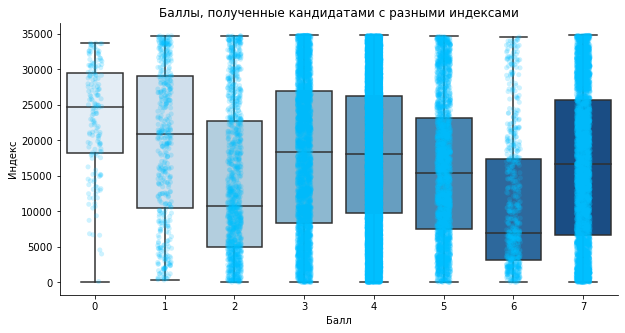

In [13]:
plt.figure(figsize=(10,5))
plt.title('Баллы, полученные кандидатами с разными индексами')
sns.boxplot(x=df['res'], y=df['ind'], whis=np.inf, palette = 'Blues')
sns.stripplot(x=df['res'], y=df['ind'], color="deepskyblue", alpha = 0.2)
plt.xlabel('Балл')
plt.ylabel('Индекс')
sns.despine()

In [14]:
#Поскольку если между результатом и индексом нет никакой связи, их среднее значение должно быть примерно одинаковым, что 
#не подтверждается графиком. Очевидно, например,  что средний индекс людей, получивших балл 6, сильно ниже тех, кто получил 0. Значит,
#возможна корреляция между индексом и баллом кандидата. Похоже, первым кандидатам больше отказавали, а последним чаще предлагали работу.

In [15]:
#Индекс возьмем за отдельный признак

In [16]:
#Теперь проверим, есть ли похожая зависимость между индексом и оценкой HR'a

Text(0, 0.5, 'Индекс')

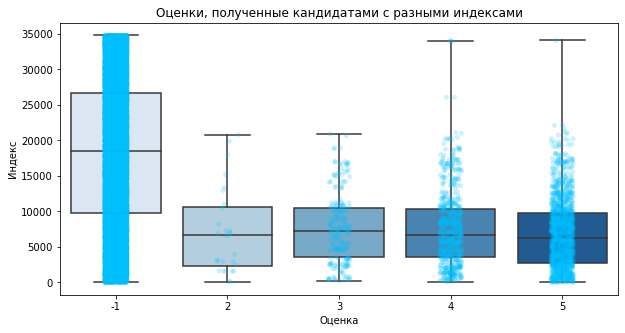

In [17]:
plt.figure(figsize=(10,5))
plt.title('Оценки, полученные кандидатами с разными индексами')
sns.boxplot(x=df['mark'], y=df['ind'], whis=np.inf, palette = 'Blues')
sns.stripplot(x=df['mark'], y=df['ind'], color="deepskyblue", alpha = 0.2)
plt.xlabel('Оценка')
plt.ylabel('Индекс')

In [18]:
#Заметен следующий паттерн: последние кандидаты практически никогда не получали оценнку выше -1, что едва ли связано с их низкой квали-
#фикацией, поскольку на предыдущем графике похожей тенденции не прослеживается. Вероятнее всего, HR к тому моменту уже набрал команду
#или последние резюме были присланы слишком поздно. Это уже говорит о несоответствии между баллом агентства и оценкой HR'a.

In [19]:
#Изобразим график соответствия между баллом агентства и оценкой HR'a

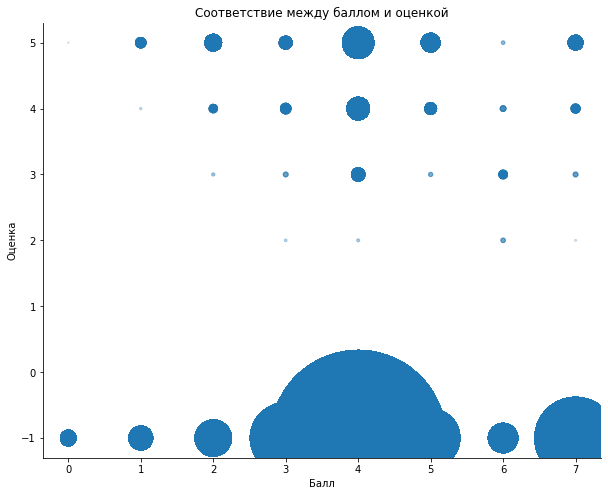

In [20]:
c = Counter(zip(df['res'],df['mark']))
s = [1.5*c[(xx,yy)] for xx,yy in zip(df['res'],df['mark'])]
plt.figure(figsize=(10,8))
plt.scatter(x = df['res'], y = df['mark'], alpha = 1/15, s=s)
plt.title('Соответствие между баллом и оценкой')
plt.xlabel('Балл')
plt.ylabel('Оценка')
sns.despine()

In [21]:
#Как видно, между данными показателями нет четкого соответствия. Так, например, оценки 5 и -1 встречаются для кандидатов с баллом от 0 до 7.
#По этому графику сложно соотнести оценки с баллами, но видно, что ошибка HR'a будет существенной.

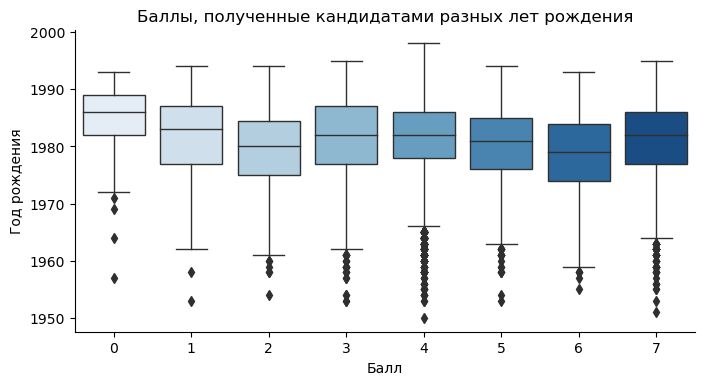

In [22]:
plt.figure(figsize=(8, 4), dpi=100)
sns.despine()
sns.boxplot(x = data['res'], y=data['birth_year'], palette='Blues',linewidth=1)
plt.title('Баллы, полученные кандидатами разных лет рождения')
plt.xlabel('Балл')
plt.ylabel('Год рождения')
sns.despine()

In [23]:
#Средний возраст кандидатов по всем баллам примерно одинаков, однако у людей, получивших job offer, средний возраст самый низкий и
#дисперсия самая маленькая. Возможно, агентство больше отдавало предпочтение молодым кандидатам. Этот признак может оказаться существенным
#в модели.

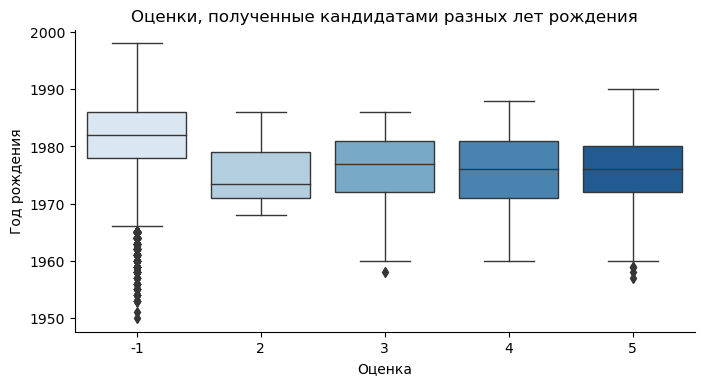

In [24]:
plt.figure(figsize=(8, 4), dpi=100)
sns.despine()
sns.boxplot(x = data['mark'], y=data['birth_year'], palette='Blues',linewidth=1)
plt.title('Оценки, полученные кандидатами разных лет рождения')
plt.xlabel('Оценка')
plt.ylabel('Год рождения')
sns.despine()

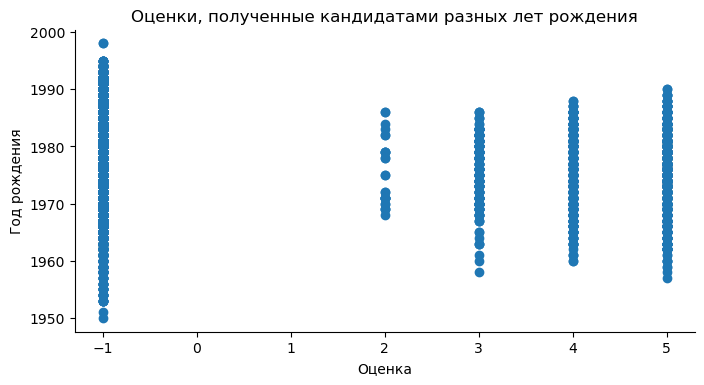

In [25]:
plt.figure(figsize=(8, 4), dpi=100)
plt.scatter(df.mark, df.birth_year)
plt.title('Оценки, полученные кандидатами разных лет рождения')
plt.xlabel('Оценка')
plt.ylabel('Год рождения')
sns.despine()

In [26]:
#Если построим такой же график, только по оси х отметим не баллы, а оценки рекрутера, то увидим несколько иную картину: напротив,
#средний возраст кандидатов, которым поставили -1, оказался ниже, чем в других группа. То есть молодым кандидатам рекрутер часто отказывал.

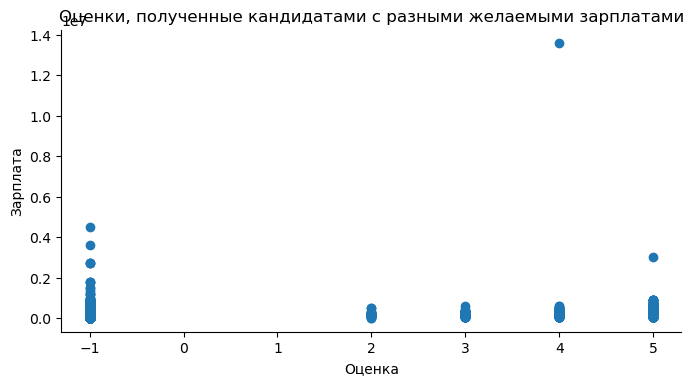

In [27]:
plt.figure(figsize=(8, 4), dpi=100)
plt.scatter(df.mark, df.price_cur)
plt.title('Оценки, полученные кандидатами с разными желаемыми зарплатами')
plt.xlabel('Оценка')
plt.ylabel('Зарплата')
sns.despine()

In [28]:
#На графике заметны выбросы в зарплате. Устраним их.

In [29]:
df = df[np.abs(df.price_cur-df.price_cur.mean()) <= (3*df.price_cur.std())]

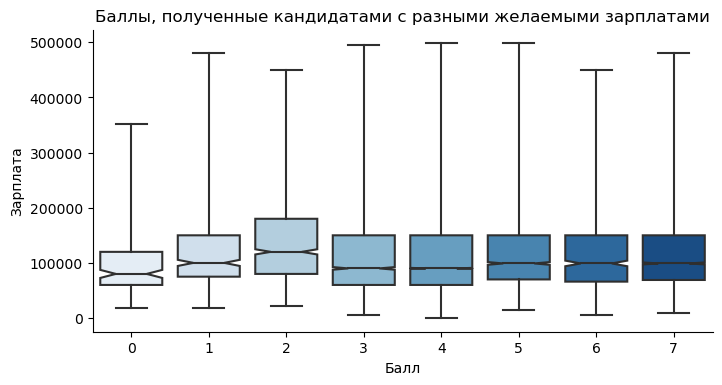

In [30]:
plt.figure(figsize=(8, 4), dpi=100)
sns.boxplot(x=df['res'], y=df['price_cur'], whis=np.inf, palette = 'Blues', notch = 1)
plt.title('Баллы, полученные кандидатами с разными желаемыми зарплатами')
plt.xlabel('Балл')
plt.ylabel('Зарплата')
sns.despine()

In [31]:
#На графике не наблюдается сильной корреляцией между желаемой зарплатой кандидата и баллом, однако у первых трех групп (с баллами 0,1,2)
#средняя зарплата несколько колеблется и повышается с увеличением балла.

In [34]:
#Что же касается рекрутера, то он часто ставил оценку 5 людям с более высокими требованиям и -1 - с низкими.

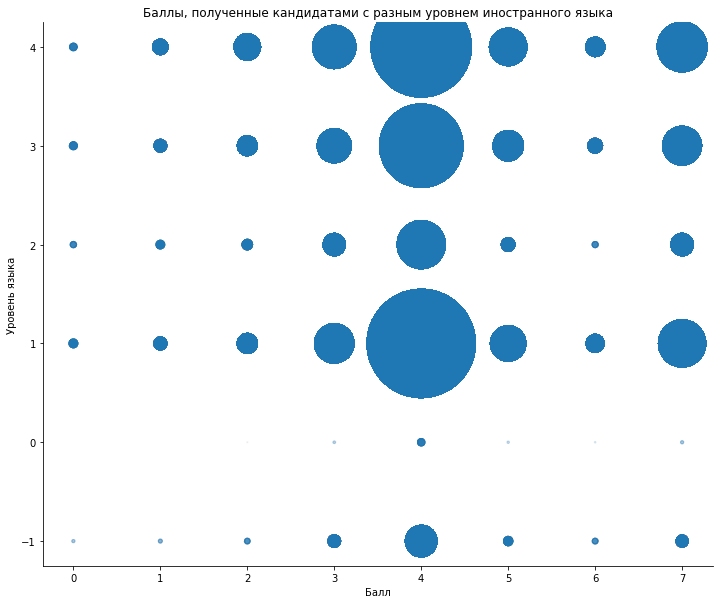

In [55]:
c = Counter(zip(df['res'],df['languages_level']))
s = [1.5*c[(xx,yy)] for xx,yy in zip(df['res'],df['languages_level'])]
plt.figure(figsize=(12,10))
plt.scatter(x = df['res'], y = df['languages_level'], alpha = 1/15, s=s)
plt.title('Баллы, полученные кандидатами с разным уровнем иностранного языка')
plt.xlabel('Балл')
plt.ylabel('Уровень языка')
sns.despine()

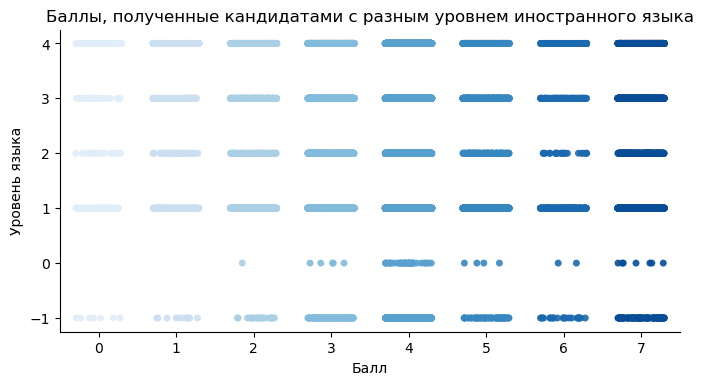

In [198]:
plt.figure(figsize=(8, 4), dpi=100)
sns.stripplot(x = df['res'], y = df['languages_level'], alpha=.90, jitter = 0.3, palette = 'Blues')
plt.title('Баллы, полученные кандидатами с разным уровнем иностранного языка')
plt.xlabel('Балл')
plt.ylabel('Уровень языка')
sns.despine()

In [37]:
#Четких выводов о зависимости уровня языка и балла сделать нельзя. Единственное: кандидату с уровнем языка 0 присваивали статус "интересен"
#на будущее. Возможно, этот признак пригодится, но едва ли окажется определяющим.

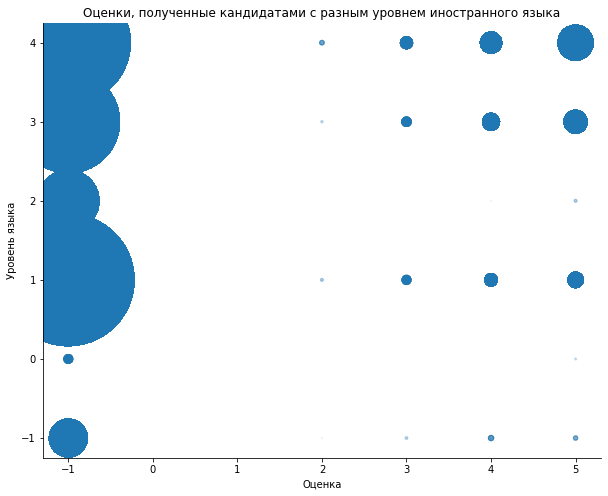

In [199]:
c = Counter(zip(df['mark'],df['languages_level']))
s = [1.5*c[(xx,yy)] for xx,yy in zip(df['mark'],df['languages_level'])]
plt.figure(figsize=(10,8))
plt.scatter(x = df['mark'], y = df['languages_level'], alpha = 1/15, s=s)
plt.title('Оценки, полученные кандидатами с разным уровнем иностранного языка')
plt.xlabel('Оценка')
plt.ylabel('Уровень языка')
sns.despine()

In [39]:
#Балл -1 ставился людям со любым уровнем языка, тогда как чем лучше уровень языка, тем выше оценка. Похоже, шкала начинается от -1 -
#отказ и заканчивается 5 - job offer.

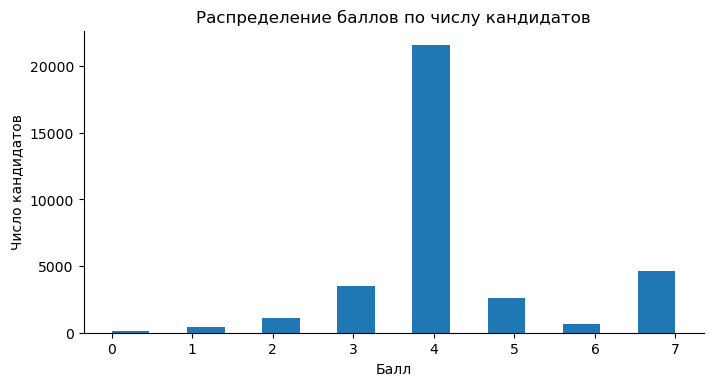

In [201]:
plt.figure(figsize=(8, 4), dpi=100)
data.res.plot.hist(bins=15)
plt.title('Распределение баллов по числу кандидатов')
plt.xlabel('Балл')
plt.ylabel('Число кандидатов')
sns.despine()

In [41]:
#Распределние баллов близко к нормальному.

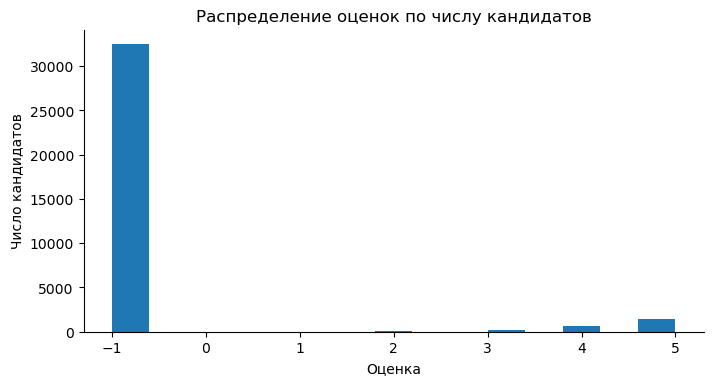

In [203]:
plt.figure(figsize=(8, 4), dpi=100)
data.mark.plot.hist(bins=15)
plt.title('Распределение оценок по числу кандидатов')
plt.xlabel('Оценка')
plt.ylabel('Число кандидатов')
sns.despine()

In [43]:
#В случае с оценкой ничего подобного нет. Большая часть кандидатов получила -1. Скорее всего, им было отказано.

In [44]:
df

,res,res_word,mark,birth_year,price_cur,languages_level,ind
0,3,в работе в FF,-1,1981,300000,4,0
1,3,в работе в FF,5,1976,450000,4,1
2,3,в работе в FF,5,1976,450000,4,2
3,4,интересен на будущее,5,1976,450000,4,3
4,4,интересен на будущее,-1,1981,210000,4,4
...,...,...,...,...,...,...,...
34788,7,отобран,-1,1990,50000,3,34788
34789,7,отобран,-1,1986,70000,3,34789
34790,3,в работе в FF,-1,1987,150000,2,34790
34791,3,в работе в FF,-1,1981,220000,2,34791


In [45]:
#Сведем проблему к задаче бинарной классификации, присвоив баллам (0,1,2,3,7) значение 1, а остальным -1.

In [46]:
df['res']=df['res'].replace([0,1,2,3,7], 1)
df['res']=df['res'].replace([4,5,6], -1)

<ipython-input-46-78a4284535eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res']=df['res'].replace([0,1,2,3,7], 1)
<ipython-input-46-78a4284535eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res']=df['res'].replace([4,5,6], -1)


In [47]:
df

,res,res_word,mark,birth_year,price_cur,languages_level,ind
0,1,в работе в FF,-1,1981,300000,4,0
1,1,в работе в FF,5,1976,450000,4,1
2,1,в работе в FF,5,1976,450000,4,2
3,-1,интересен на будущее,5,1976,450000,4,3
4,-1,интересен на будущее,-1,1981,210000,4,4
...,...,...,...,...,...,...,...
34788,1,отобран,-1,1990,50000,3,34788
34789,1,отобран,-1,1986,70000,3,34789
34790,1,в работе в FF,-1,1987,150000,2,34790
34791,1,в работе в FF,-1,1981,220000,2,34791


In [48]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,res,mark,birth_year,price_cur,languages_level,ind
res,1.000000,0.026035,-0.016489,0.042985,0.053858,-0.024563
mark,0.026035,1.000000,-0.218825,0.254170,0.141013,-0.269774
birth_year,-0.016489,-0.218825,1.000000,-0.479018,-0.088502,0.443255
price_cur,0.042985,0.254170,-0.479018,1.000000,0.352360,-0.413196
languages_level,0.053858,0.141013,-0.088502,0.352360,1.000000,-0.350661
ind,-0.024563,-0.269774,0.443255,-0.413196,-0.350661,1.000000


In [49]:
#Удивительна корреляция между уровнем языка и индексом. Это лишний раз доказывает неслучайность индексации. Ни у какой переменной не
#наблюдается сильной корреляции с баллом. В свою очередь оценка отрицательно коррелирует с годом рождения и индексом 
#и положительно - с зарплатой.

In [50]:
X = df[['price_cur', 'birth_year', 'languages_level', 'ind']]
y = df['res']

In [51]:
#Выделяем подвыборку для сложно обучаемых моделей.

In [52]:
sam = df.sample(5000)
X_sam = sam[['price_cur', 'birth_year', 'languages_level', 'ind']]
y_sam = sam['res']

In [53]:
#Нормируем матрицу объект-признак для kNN

In [54]:
X_norm = normalize(X, axis = 0)
X_samnorm = normalize(X_sam, axis = 0)

In [55]:
#Разбиваем выборку на 5 фолдов с рандомизацией

In [56]:
kfold = KFold(n_splits = 5, shuffle=True, random_state=0)

In [57]:
#Обычный градиентный спуск работал очень долго, поэтому прибегли к его более ускоренной альтернативе - стохастическому градиентному спуску.

In [58]:
#Подбираем оптимальные параметры для SGD-классификатора

In [59]:
a=0
for loss1 in ('epsilon_insensitive', 'squared_epsilon_insensitive', 'hinge', 'squared_loss', 'huber'):
    for alpha1 in np.linspace(0.0001, 1, num = 1000):
        
        clf = SGDClassifier(loss=loss1, penalty='l1', tol = 1e-6, random_state = 0, max_iter = 1000000, alpha = alpha1, n_jobs = -1)
        scores = cross_val_score(clf, X, y, cv = kfold, scoring = 'f1')
        if np.mean(scores)>a:
            a = np.mean(scores)
            print('f1 = ', a, 'loss = ', loss1, 'alpha = ', alpha1)

f1 =  0.07758286281289364 loss =  epsilon_insensitive alpha =  0.0001
f1 =  0.1768309213930756 loss =  epsilon_insensitive alpha =  0.001100900900900901
f1 =  0.3564129548674474 loss =  epsilon_insensitive alpha =  0.0021018018018018015
f1 =  0.35664247846216535 loss =  epsilon_insensitive alpha =  0.0071063063063063064
f1 =  0.44275474913862956 loss =  epsilon_insensitive alpha =  0.014112612612612612
f1 =  0.44354782666183723 loss =  epsilon_insensitive alpha =  0.1172054054054054
f1 =  0.4435480799635254 loss =  epsilon_insensitive alpha =  0.17826036036036033


KeyboardInterrupt: 

In [ ]:
'''f1 =  0.07758286281289364 loss =  epsilon_insensitive alpha =  0.0001
f1 =  0.1768309213930756 loss =  epsilon_insensitive alpha =  0.001100900900900901
f1 =  0.3564129548674474 loss =  epsilon_insensitive alpha =  0.0021018018018018015
f1 =  0.35664247846216535 loss =  epsilon_insensitive alpha =  0.0071063063063063064
f1 =  0.44275474913862956 loss =  epsilon_insensitive alpha =  0.014112612612612612
f1 =  0.44354782666183723 loss =  epsilon_insensitive alpha =  0.1172054054054054
f1 =  0.4435480799635254 loss =  epsilon_insensitive alpha =  0.17826036036036033'''

In [ ]:
#Производим обучение и тест с оптимальными параметрами на кросс-валидации

In [60]:
sgd1 = SGDClassifier(loss='epsilon_insensitive', penalty="l1", tol = 1e-6, random_state = 0, max_iter = 1000000, alpha = 0.17826036036036033)

In [61]:
#Оцениваем качество с помощью f-меры, меры полноты, точности и accuracy.

In [62]:
SGD_f1 = cross_val_score(sgd1, X, y, cv = kfold, scoring = 'f1')
print(SGD_f1, '\n', np.mean(SGD_f1))

[0.44379299 0.43542352 0.43798099 0.45135226 0.44919065] 
 0.4435480799635254


In [63]:
SGD_accuracy = cross_val_score(sgd1, X, y, cv = kfold, scoring = 'accuracy')
print(SGD_accuracy, '\n', np.mean(SGD_accuracy))

[0.28527963 0.27851036 0.28039415 0.29155195 0.28995798] 
 0.2851388123567862


In [64]:
SGD_precision = cross_val_score(sgd1, X, y, cv = kfold, scoring = 'precision')
print(SGD_precision, '\n', np.mean(SGD_precision))

[0.28517606 0.2783012  0.28039415 0.29144928 0.28964917] 
 0.2849939718650204


In [65]:
SGD_recall = cross_val_score(sgd1, X, y, cv = kfold, scoring = 'recall')
print(SGD_recall, '\n', np.mean(SGD_recall))

[1. 1. 1. 1. 1.] 
 1.0


In [ ]:
#SGD демонстрирует высокий recall, то есть модель хорошо "вылавливает" интересных кандидатов.

In [ ]:
#Теперь подбираем параметры для kNN, проводим все те же процедуры

In [69]:
f1 = 0
for p1 in (1,2):
    for weights1 in ('uniform','distance'):
        for n in range(1, 200):
            clf = KNeighborsClassifier(p = p1, weights = weights1, n_neighbors = n)
            scores = cross_val_score(clf, X_norm, y, cv = kfold, scoring = 'f1')
            if f1<np.mean(scores):
                f1 = np.mean(scores)
                print('f1 = ', f1, 'p = ', p1, 'weights = ', weights1, 'n = ', n)

f1 =  0.3371531825643975 p =  1 weights =  uniform n =  1


KeyboardInterrupt: 

In [ ]:
'''f1 =  0.3371531825643975 p =  1 weights =  uniform n =  1'''

In [ ]:
'''f1 =  0.2725439272443312 p =  1 weights =  uniform
f1 =  0.31651296785712907 p =  1 weights =  distance
f1 =  0.31683727786064375 p =  2 weights =  distance'''

In [70]:
knn1 = KNeighborsClassifier(p =  1, weights =  'uniform', n_neighbors = 1)
kNN_f1 = cross_val_score(knn1, X_norm, y, cv = kfold, scoring = 'f1')
print(kNN_f1, '\n', np.mean(kNN_f1))

[0.33290323 0.33883668 0.33282051 0.34289955 0.33830594] 
 0.3371531825643975


In [71]:
kNN_accuracy = cross_val_score(knn1, X_norm, y, cv = kfold, scoring = 'accuracy')
print(kNN_accuracy, '\n', np.mean(kNN_accuracy))

[0.62547088 0.62280829 0.6229532  0.61512824 0.6207796 ] 
 0.621428040258571


In [72]:
kNN_precision = cross_val_score(knn1, X_norm, y, cv = kfold, scoring = 'precision')
print(kNN_precision, '\n', np.mean(kNN_precision))

[0.33822758 0.33068914 0.3302799  0.34121123 0.34184977] 
 0.3364515238306141


In [73]:
kNN_recall = cross_val_score(knn1, X_norm, y, cv = kfold, scoring = 'recall')
print(kNN_recall, '\n', np.mean(kNN_recall))

[0.3277439  0.34739583 0.33540052 0.34460467 0.33483483] 
 0.3379959523388911


In [74]:
f1 = 0
for weights1 in ('uniform','distance'):
    for n in range(1, 200): 
        clf = KNeighborsClassifier(weights = weights1, metric='chebyshev', n_neighbors = n)
        scores = cross_val_score(clf, X_norm, y, cv = kfold, scoring = 'f1')
        if f1<np.mean(scores):
            f1 = np.mean(scores)
            print('f1 = ', f1, 'p = ', p1, 'weights = ', weights1, 'n = ', n)

f1 =  0.3318618574551334 p =  1 weights =  uniform n =  1


KeyboardInterrupt: 

In [ ]:
'''f1 =  0.3318618574551334 p =  1 weights =  uniform n =  1'''

In [ ]:
#Метрика Чебышева хуже

In [75]:
knn2 = KNeighborsClassifier(n_neighbors = 1, weights = 'distance', metric='mahalanobis', metric_params={'V': np.cov(X_samnorm, rowvar=False)})

In [ ]:
scores = cross_val_score(knn2, X_samnorm, y_sam, cv = kfold, scoring = 'f1')
print(scores, '\n', np.mean(scores))

In [ ]:
f1 = 0
params={'V': np.cov(X_samnorm, rowvar=False)}
for weights1 in ('uniform','distance'):
    for n in range(1, 50): 
        clf = KNeighborsClassifier(weights = weights1, metric='mahalanobis', n_neighbors = n, metric_params= params)
        scores = cross_val_score(clf, X_samnorm, y_sam, cv = kfold, scoring = 'f1')
        if f1<np.mean(scores):
            f1 = np.mean(scores)
            print('f1 = ', f1, 'weights = ', weights1, 'n = ', n)

In [ ]:
'''f1 =  0.31573841806880487 weights =  uniform n =  1'''

In [ ]:
#Расстояние Махаланобиса хуже

In [ ]:
#Строим логистическую регрессию. Для начала проверим существенность переменных.

In [ ]:
X = df[['birth_year', 'price_cur', 'languages_level', 'ind']]
y = df['res']

In [ ]:
y=y.replace(-1, 0)

In [ ]:
logit = sm.Logit(y, X)

In [ ]:
res = logit.fit()

In [ ]:
res.summary()

In [ ]:
#Удалим ind, поскольку он несущественен на уровне значимости 0,05, хотя в предыдущие модели ухудшали свою предсказательную способность при
#удалении этой переменной.

In [ ]:
X = df[['birth_year',  'price_cur', 'languages_level']]

In [ ]:
logit1 = sm.Logit(y, X)

In [ ]:
res1 = logit1.fit()

In [ ]:
res1.summary()

In [ ]:
Counter(y)

In [ ]:
logit1 = LogisticRegression(penalty = 'l2', tol = 1e-6, C = 1, max_iter = 1000000, multi_class = 'ovr', random_state=0, solver = 'lbfgs', class_weight= 'balanced')

In [ ]:
scores = cross_val_score(logit1, X, y, cv = kfold, scoring = 'f1')
print(scores, '\n', np.mean(scores))

In [ ]:
logit2 = LogisticRegression(penalty = 'l2', dual = True, tol = 1e-6, C = 1, max_iter = 1000000, multi_class = 'ovr', random_state=0, solver = 'lbfgs', class_weight= 'balanced')

In [ ]:
scores = cross_val_score(logit2, X, y, cv = kfold, scoring = 'f1')
print(scores, '\n', np.mean(scores))

In [76]:
f1 = 0
for solver1 in ('newton-cg', 'lbfgs', 'liblinear'):
    for C1 in np.linspace(0, 1, 100):
        clf = LogisticRegression(penalty = 'l2', tol = 1e-6, C = C1, max_iter = 1000000, multi_class = 'ovr', random_state=0, solver = solver1, class_weight= 'balanced')
        scores = cross_val_score(clf, X, y, cv = kfold, scoring = 'f1')
        if f1<np.mean(scores):
            f1 = np.mean(scores)
            print('f1 = ', f1, 'solver = ', solver1, 'C =  ', C1)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:767: RuntimeWarning: divide by zero encountered in double_scalars
  args = (X, target, 1. / C, sample_weight)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:167: RuntimeWarning: invalid value encountered in double_scalars
  out = -np.sum(sample_weight * log_logistic(yz)) + .5 * alpha * np.dot(w, w)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:213: RuntimeWarning: invalid value encountered in multiply
  grad[:n_features] = safe_sparse_dot(X.T, z0) + alpha * w
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train,

f1 =  0.3922283608467151 solver =  newton-cg C =   0.010101010101010102


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packag

f1 =  0.39256249214859923 solver =  newton-cg C =   0.030303030303030304


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packag

f1 =  0.3926603085664063 solver =  newton-cg C =   0.09090909090909091


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line se

KeyboardInterrupt: 

In [ ]:
'''f1 =  0.4000703623596227 solver =  liblinear C =   0.05050505050505051'''

In [ ]:
f1 = 0
for penalty1 in ('l1', 'l2'):
    for C1 in np.linspace(0, 1, 100):
        clf = LogisticRegression(penalty = penalty1, tol = 1e-6, C = C1, max_iter = 1000000, multi_class = 'ovr', random_state=0, solver = 'liblinear', class_weight= 'balanced')
        scores = cross_val_score(clf, X_norm, y, cv = kfold, scoring = 'f1')
        if f1<np.mean(scores):
            f1 = np.mean(scores)
            print('f1 = ', f1, 'penalty = ', penalty1, 'C =  ', C1)

In [ ]:
'''f1 =  0.3319539899106484 penalty =  l2 C =   0.010101010101010102'''

In [77]:
logit3 = LogisticRegression(penalty = 'l2', tol = 1e-6, max_iter = 1000000, multi_class = 'ovr', random_state=0, solver =  'liblinear', C = 0.05050505050505051, class_weight= 'balanced')

In [78]:
Logit_f1 = cross_val_score(logit3, X, y, cv = kfold, scoring = 'f1')
print(Logit_f1, '\n', np.mean(Logit_f1))

[0.40007348 0.38340643 0.38918346 0.39098551 0.39641616] 
 0.3920130082898897


In [79]:
Logit_accuracy = cross_val_score(logit3, X, y, cv = kfold, scoring = 'accuracy')
print(Logit_accuracy, '\n', np.mean(Logit_accuracy))

[0.52680382 0.51108535 0.49920301 0.50659325 0.52166353] 
 0.5130697926728016


In [80]:
Logit_precision = cross_val_score(logit3, X, y, cv = kfold, scoring = 'precision')
print(Logit_precision, '\n', np.mean(Logit_precision))

[0.31329114 0.29532658 0.29572925 0.30530726 0.31230193] 
 0.304391231854145


In [81]:
Logit_recall = cross_val_score(logit3, X, y, cv = kfold, scoring = 'recall')
print(Logit_recall, '\n', np.mean(Logit_recall))

[0.55335366 0.54635417 0.56899225 0.54351069 0.54254254] 
 0.5509506614012437


In [ ]:
#Перейдем к построению случайного леса

In [ ]:
X = df[['birth_year',  'price_cur', 'languages_level', 'ind']]

In [ ]:
forest1 = RandomForestClassifier(n_estimators=100)

In [ ]:
scores = cross_val_score(forest1, X, y, cv = kfold, scoring = 'f1')
print(scores, '\n', np.mean(scores))

In [ ]:
f1=0
for criterion1 in ('gini', 'entropy'):
    for min_samples_leaf1 in range (1,10):
        for class_weight1 in ('balanced', 'balanced_subsample', None):
            for n in range(1, 25):
                for max_features1 in range(1,5):
                    clf = RandomForestClassifier(criterion = criterion1, min_samples_leaf = min_samples_leaf1, class_weight = class_weight1, n_estimators = n, n_jobs = -1)
                    scores = cross_val_score(clf, X, y, cv = kfold, scoring = 'f1')
                    if f1<np.mean(scores):
                        f1=np.mean(scores)
                        print('f1 = ', f1, 'criterion = ', criterion1, 'min_samples_leaf = ', min_samples_leaf1, 'class_weight = ', class_weight1, 'n = ', n,  'max_features = ', max_features1)
        

In [ ]:
'''f1 =  0.32715504802361284 criterion =  gini min_samples_leaf =  1 class_weight =  balanced n =  1 max_features =  1
f1 =  0.33390956498996793 criterion =  gini min_samples_leaf =  1 class_weight =  None n =  1 max_features =  4
f1 =  0.3752287884343096 criterion =  gini min_samples_leaf =  2 class_weight =  balanced n =  1 max_features =  1
f1 =  0.375890369410026 criterion =  gini min_samples_leaf =  3 class_weight =  balanced_subsample n =  1 max_features =  3
f1 =  0.37792441383975833 criterion =  gini min_samples_leaf =  4 class_weight =  balanced n =  1 max_features =  3
f1 =  0.3799271767680597 criterion =  gini min_samples_leaf =  4 class_weight =  balanced n =  1 max_features =  4
f1 =  0.38516040765961446 criterion =  gini min_samples_leaf =  4 class_weight =  balanced_subsample n =  1 max_features =  4
f1 =  0.385490066173639 criterion =  gini min_samples_leaf =  7 class_weight =  balanced n =  3 max_features =  3
f1 =  0.38742026550181 criterion =  gini min_samples_leaf =  7 class_weight =  balanced n =  7 max_features =  3
f1 =  0.38779253539838304 criterion =  gini min_samples_leaf =  7 class_weight =  balanced_subsample n =  7 max_features =  1
f1 =  0.3891996083151778 criterion =  gini min_samples_leaf =  7 class_weight =  balanced_subsample n =  10 max_features =  3
f1 =  0.38926381986724157 criterion =  gini min_samples_leaf =  8 class_weight =  balanced n =  1 max_features =  2
f1 =  0.3902967531237982 criterion =  gini min_samples_leaf =  8 class_weight =  balanced n =  1 max_features =  4
f1 =  0.39107288086221365 criterion =  gini min_samples_leaf =  8 class_weight =  balanced n =  8 max_features =  3
f1 =  0.3915793917477128 criterion =  gini min_samples_leaf =  8 class_weight =  balanced n =  8 max_features =  4
f1 =  0.3919149219687515 criterion =  gini min_samples_leaf =  8 class_weight =  balanced n =  10 max_features =  1
f1 =  0.3920878548815853 criterion =  gini min_samples_leaf =  8 class_weight =  balanced n =  18 max_features =  2
f1 =  0.3934225518687173 criterion =  gini min_samples_leaf =  9 class_weight =  balanced n =  10 max_features =  1
f1 =  0.3946026704521945 criterion =  gini min_samples_leaf =  9 class_weight =  balanced n =  18 max_features =  2'''

In [ ]:
f1=0
for min_samples_leaf1 in range (1,10):
    for class_weight1 in ('balanced', 'balanced_subsample', None):
        for n in range(1, 25):
            for max_features1 in range(1,5):
                clf = RandomForestClassifier(criterion = 'entropy', min_samples_leaf = min_samples_leaf1, class_weight = class_weight1, n_estimators = n, n_jobs = -1)
                scores = cross_val_score(clf, X, y, cv = kfold, scoring = 'f1')
                if f1<np.mean(scores):
                    f1=np.mean(scores)
                    print('f1 = ', f1, 'min_samples_leaf = ', min_samples_leaf1, 'class_weight = ', class_weight1, 'n = ', n,  'max_features = ', max_features1)
        

In [ ]:
'''f1 =  0.32378917694793524 min_samples_leaf =  1 class_weight =  balanced n =  1 max_features =  1
f1 =  0.3257065583481453 min_samples_leaf =  1 class_weight =  balanced n =  1 max_features =  3
f1 =  0.3288315859405935 min_samples_leaf =  1 class_weight =  balanced_subsample n =  1 max_features =  3
f1 =  0.33396838882235597 min_samples_leaf =  1 class_weight =  None n =  1 max_features =  4
f1 =  0.36421743545601026 min_samples_leaf =  2 class_weight =  balanced n =  1 max_features =  1
f1 =  0.3667317902680064 min_samples_leaf =  2 class_weight =  balanced n =  1 max_features =  2
f1 =  0.36874061708350286 min_samples_leaf =  2 class_weight =  balanced n =  1 max_features =  4
f1 =  0.3693435654916334 min_samples_leaf =  2 class_weight =  balanced_subsample n =  1 max_features =  4
f1 =  0.3710425174951343 min_samples_leaf =  3 class_weight =  balanced n =  1 max_features =  3
f1 =  0.37323000916020266 min_samples_leaf =  3 class_weight =  balanced_subsample n =  1 max_features =  1
f1 =  0.3789681446555728 min_samples_leaf =  4 class_weight =  balanced n =  1 max_features =  1
f1 =  0.37898422579142366 min_samples_leaf =  5 class_weight =  balanced n =  1 max_features =  1
f1 =  0.3821648326781799 min_samples_leaf =  5 class_weight =  balanced n =  1 max_features =  4
f1 =  0.3840416510061095 min_samples_leaf =  5 class_weight =  balanced_subsample n =  1 max_features =  1
f1 =  0.3868145824481485 min_samples_leaf =  6 class_weight =  balanced n =  1 max_features =  1
f1 =  0.38842630009479145 min_samples_leaf =  6 class_weight =  balanced_subsample n =  1 max_features =  2
f1 =  0.3897647469840332 min_samples_leaf =  7 class_weight =  balanced n =  1 max_features =  3
f1 =  0.39000182439187825 min_samples_leaf =  7 class_weight =  balanced n =  6 max_features =  1
f1 =  0.39083963314562015 min_samples_leaf =  8 class_weight =  balanced n =  4 max_features =  3
f1 =  0.3908523106711566 min_samples_leaf =  8 class_weight =  balanced n =  14 max_features =  1
f1 =  0.3919064830401921 min_samples_leaf =  9 class_weight =  balanced n =  4 max_features =  3
f1 =  0.3924584408456993 min_samples_leaf =  9 class_weight =  balanced n =  5 max_features =  2
f1 =  0.39324772135431696 min_samples_leaf =  9 class_weight =  balanced n =  7 max_features =  3
f1 =  0.39358108173494816 min_samples_leaf =  9 class_weight =  balanced n =  13 max_features =  1
f1 =  0.39379432426305233 min_samples_leaf =  9 class_weight =  balanced_subsample n =  3 max_features =  4
f1 =  0.3965875195313616 min_samples_leaf =  9 class_weight =  balanced_subsample n =  24 max_features =  4'''

In [ ]:
f1=0
for min_samples_leaf1 in range (10, 20):
    for class_weight1 in ('balanced', 'balanced_subsample', None):
        for n in range(1, 30):
            for max_features1 in range(1,5):
                clf = RandomForestClassifier(criterion = 'entropy', min_samples_leaf = min_samples_leaf1, class_weight = class_weight1, n_estimators = n, n_jobs = -1, max_features = max_features1)
                scores = cross_val_score(clf, X, y, cv = kfold, scoring = 'f1')
                if f1<np.mean(scores):
                    f1=np.mean(scores)
                    print('f1 = ', f1, 'min_samples_leaf = ', min_samples_leaf1, 'class_weight = ', class_weight1, 'n = ', n,  'max_features = ', max_features1)
        

In [ ]:
'''f1 =  0.39271324078009 min_samples_leaf =  10 class_weight =  balanced n =  1 max_features =  1
f1 =  0.39391446422171866 min_samples_leaf =  10 class_weight =  balanced n =  6 max_features =  3
f1 =  0.3946138593823397 min_samples_leaf =  10 class_weight =  balanced n =  8 max_features =  2
f1 =  0.39588740275491496 min_samples_leaf =  10 class_weight =  balanced n =  8 max_features =  4
f1 =  0.3962420644856691 min_samples_leaf =  10 class_weight =  balanced n =  18 max_features =  1
f1 =  0.39781569178295995 min_samples_leaf =  10 class_weight =  balanced_subsample n =  14 max_features =  3
f1 =  0.39913368968358637 min_samples_leaf =  11 class_weight =  balanced n =  19 max_features =  1
f1 =  0.3992484458549728 min_samples_leaf =  11 class_weight =  balanced_subsample n =  15 max_features =  4
f1 =  0.3997816326985419 min_samples_leaf =  12 class_weight =  balanced n =  8 max_features =  4
f1 =  0.4004889089464664 min_samples_leaf =  12 class_weight =  balanced n =  13 max_features =  2
f1 =  0.4015780403812393 min_samples_leaf =  12 class_weight =  balanced n =  16 max_features =  3
f1 =  0.4030583326722776 min_samples_leaf =  12 class_weight =  balanced_subsample n =  20 max_features =  4
f1 =  0.40454595464686377 min_samples_leaf =  13 class_weight =  balanced_subsample n =  13 max_features =  2'''

In [82]:
forest2 = RandomForestClassifier(criterion = 'entropy', min_samples_leaf = 13, class_weight = 'balanced_subsample', n_estimators = 13, n_jobs = -1, max_features = 2)



In [83]:
Forest_f1 = cross_val_score(forest2, X, y, cv = kfold, scoring = 'f1', n_jobs = -1)
print(Forest_f1, '\n', np.mean(Forest_f1))

[0.39064649 0.40346874 0.40359147 0.39677047 0.38518519] 
 0.3959324713020263


In [84]:
Forest_accuracy = cross_val_score(forest2, X, y, cv = kfold, scoring = 'accuracy', n_jobs = -1)
print(Forest_accuracy, '\n', np.mean(Forest_accuracy))

[0.6172124  0.61744675 0.61063614 0.61483843 0.60295609] 
 0.6126179622546819


In [85]:
Forest_precision = cross_val_score(forest2, X, y, cv = kfold, scoring = 'precision', n_jobs = -1)
print(Forest_precision, '\n', np.mean(Forest_precision))

[0.3590797  0.35032103 0.35151274 0.36842105 0.35227731] 
 0.3563223661000635


In [86]:
Forest_recall = cross_val_score(forest2, X, y, cv = kfold, scoring = 'recall', n_jobs = -1)
print(Forest_recall, '\n', np.mean(Forest_recall))

[0.44410569 0.46927083 0.45064599 0.44306315 0.42342342] 
 0.4461018190612154


In [ ]:
#Построим ансамбль на базе уже построенных моделей

In [87]:
ensem = VotingClassifier(estimators = [('sgd', sgd1), ('logit', logit3), ('forest', forest2)], voting = 'hard')


In [89]:
ensem_f1 = cross_val_score(ensem, X, y, cv = kfold, scoring = 'f1', n_jobs = -1)
print(ensem_f1, '\n', np.mean(ensem_f1))

[0.44949099 0.42850532 0.43937793 0.44468053 0.43658915] 
 0.4397287833960034


In [91]:
ensem_accuracy = cross_val_score(ensem, X, y, cv = kfold, scoring = 'accuracy', n_jobs = -1)
print(ensem_accuracy, '\n', np.mean(ensem_accuracy))

[0.48536656 0.46688886 0.46196203 0.47283002 0.47485872] 
 0.47238123847093416


In [92]:
ensem_precision = cross_val_score(ensem, X, y, cv = kfold, scoring = 'precision', n_jobs = -1)
print(ensem_precision, '\n', np.mean(ensem_precision))

[0.3216596  0.30789474 0.31008902 0.32190727 0.3205677 ] 
 0.3164236658223517


In [93]:
ensem_recall = cross_val_score(ensem, X, y, cv = kfold, scoring = 'recall', n_jobs = -1)
print(ensem_recall, '\n', np.mean(ensem_recall))

[0.73932927 0.72916667 0.76072351 0.72252611 0.71471471] 
 0.733292054060134


In [94]:
#Построим таблицу, резюмирующую результаты моделей

In [95]:
d = {'fold': pd.Series(['mean', 'split_1', 'split_2', 'split_3', 'split_4', 'split_5']), 'SGD_f1': pd.Series((np.mean(SGD_f1), *SGD_f1)), 'SGD_accuracy': pd.Series((np.mean(SGD_accuracy), *SGD_accuracy)), 'SGD_precision': pd.Series((np.mean(SGD_precision), *SGD_precision)), 'SGD_recall': pd.Series((np.mean(SGD_recall), *SGD_recall)),
'kNN_f1': pd.Series((np.mean(kNN_f1), *kNN_f1)), 'kNN_accuracy': pd.Series((np.mean(kNN_accuracy), *kNN_accuracy)), 'kNN_precision': pd.Series((np.mean(kNN_precision), *kNN_precision)), 'kNN_recall': pd.Series((np.mean(kNN_recall), *kNN_recall)),
'Logit_f1': pd.Series((np.mean(Logit_f1), *Logit_f1)), 'Logit_accuracy': pd.Series((np.mean(Logit_accuracy), *Logit_accuracy)), 'Logit_precision': pd.Series((np.mean(Logit_precision), *Logit_precision)), 'Logit_recall': pd.Series((np.mean(Logit_recall), *Logit_recall)),
'Forest_f1': pd.Series((np.mean(Forest_f1), *Forest_f1)), 'Forest_accuracy': pd.Series((np.mean(Forest_accuracy), *Forest_accuracy)), 'Forest_precision': pd.Series((np.mean(Forest_precision), *Forest_precision)), 'Forest_recall': pd.Series((np.mean(Forest_recall), *Forest_recall)),
'Ensem_f1': pd.Series((np.mean(ensem_f1), *ensem_f1)), 'Ensem_accuracy': pd.Series((np.mean(ensem_accuracy), *ensem_accuracy)), 'Ensem_precision': pd.Series((np.mean(ensem_precision), *ensem_precision)), 'Ensem_recall': pd.Series((np.mean(ensem_recall), *ensem_recall))
    }



In [96]:
d

{'fold': 0       mean
 1    split_1
 2    split_2
 3    split_3
 4    split_4
 5    split_5
 dtype: object,
 'SGD_f1': 0    0.443548
 1    0.443793
 2    0.435424
 3    0.437981
 4    0.451352
 5    0.449191
 dtype: float64,
 'SGD_accuracy': 0    0.285139
 1    0.285280
 2    0.278510
 3    0.280394
 4    0.291552
 5    0.289958
 dtype: float64,
 'SGD_precision': 0    0.284994
 1    0.285176
 2    0.278301
 3    0.280394
 4    0.291449
 5    0.289649
 dtype: float64,
 'SGD_recall': 0    1.0
 1    1.0
 2    1.0
 3    1.0
 4    1.0
 5    1.0
 dtype: float64,
 'kNN_f1': 0    0.337153
 1    0.332903
 2    0.338837
 3    0.332821
 4    0.342900
 5    0.338306
 dtype: float64,
 'kNN_accuracy': 0    0.621428
 1    0.625471
 2    0.622808
 3    0.622953
 4    0.615128
 5    0.620780
 dtype: float64,
 'kNN_precision': 0    0.336452
 1    0.338228
 2    0.330689
 3    0.330280
 4    0.341211
 5    0.341850
 dtype: float64,
 'kNN_recall': 0    0.337996
 1    0.327744
 2    0.347396
 3    0.335401

In [97]:
final = pd.DataFrame(d)
final

,fold,SGD_f1,SGD_accuracy,SGD_precision,SGD_recall,kNN_f1,kNN_accuracy,kNN_precision,kNN_recall,Logit_f1,...,Logit_precision,Logit_recall,Forest_f1,Forest_accuracy,Forest_precision,Forest_recall,Ensem_f1,Ensem_accuracy,Ensem_precision,Ensem_recall
0,mean,0.443548,0.285139,0.284994,1.0,0.337153,0.621428,0.336452,0.337996,0.392013,...,0.304391,0.550951,0.395932,0.612618,0.356322,0.446102,0.439729,0.472381,0.316424,0.733292
1,split_1,0.443793,0.285280,0.285176,1.0,0.332903,0.625471,0.338228,0.327744,0.400073,...,0.313291,0.553354,0.390646,0.617212,0.359080,0.444106,0.449491,0.485367,0.321660,0.739329
2,split_2,0.435424,0.278510,0.278301,1.0,0.338837,0.622808,0.330689,0.347396,0.383406,...,0.295327,0.546354,0.403469,0.617447,0.350321,0.469271,0.428505,0.466889,0.307895,0.729167
3,split_3,0.437981,0.280394,0.280394,1.0,0.332821,0.622953,0.330280,0.335401,0.389183,...,0.295729,0.568992,0.403591,0.610636,0.351513,0.450646,0.439378,0.461962,0.310089,0.760724
4,split_4,0.451352,0.291552,0.291449,1.0,0.342900,0.615128,0.341211,0.344605,0.390986,...,0.305307,0.543511,0.396770,0.614838,0.368421,0.443063,0.444681,0.472830,0.321907,0.722526
5,split_5,0.449191,0.289958,0.289649,1.0,0.338306,0.620780,0.341850,0.334835,0.396416,...,0.312302,0.542543,0.385185,0.602956,0.352277,0.423423,0.436589,0.474859,0.320568,0.714715


In [98]:
final.columns

Index(['fold', 'SGD_f1', 'SGD_accuracy', 'SGD_precision', 'SGD_recall',
       'kNN_f1', 'kNN_accuracy', 'kNN_precision', 'kNN_recall', 'Logit_f1',
       'Logit_accuracy', 'Logit_precision', 'Logit_recall', 'Forest_f1',
       'Forest_accuracy', 'Forest_precision', 'Forest_recall', 'Ensem_f1',
       'Ensem_accuracy', 'Ensem_precision', 'Ensem_recall'],
      dtype='object')

In [99]:
final = final[['fold', 'SGD_f1', 'kNN_f1', 'Logit_f1', 'Forest_f1', 'Ensem_f1']]
final

,fold,SGD_f1,kNN_f1,Logit_f1,Forest_f1,Ensem_f1
0,mean,0.443548,0.337153,0.392013,0.395932,0.439729
1,split_1,0.443793,0.332903,0.400073,0.390646,0.449491
2,split_2,0.435424,0.338837,0.383406,0.403469,0.428505
3,split_3,0.437981,0.332821,0.389183,0.403591,0.439378
4,split_4,0.451352,0.342900,0.390986,0.396770,0.444681
5,split_5,0.449191,0.338306,0.396416,0.385185,0.436589


In [100]:
#SGD-модель оказалась лучшей по показателю f-меры

In [101]:
#Теперь оценим качество работы HR'a

In [102]:
data

,res,res_word,mark,birth_year,price_cur,languages_level,ind
0,3,в работе в FF,-1,1981,300000,4,0
1,3,в работе в FF,5,1976,450000,4,1
2,3,в работе в FF,5,1976,450000,4,2
3,4,интересен на будущее,5,1976,450000,4,3
4,4,интересен на будущее,-1,1981,210000,4,4
...,...,...,...,...,...,...,...
34788,7,отобран,-1,1990,50000,3,34788
34789,7,отобран,-1,1986,70000,3,34789
34790,3,в работе в FF,-1,1987,150000,2,34790
34791,3,в работе в FF,-1,1981,220000,2,34791


In [ ]:
3. в работе в FF', '4. интересен на будущее',
       '2. передан клиенту', '7. отобран', '5. отказано клиентом',
       '6. не интересен', '0. job offer', '1. интервью у клиента'],
      dtype=object)

([<matplotlib.axis.YTick at 0x7fa97d56f220>], [Text(0, 0, '7')])

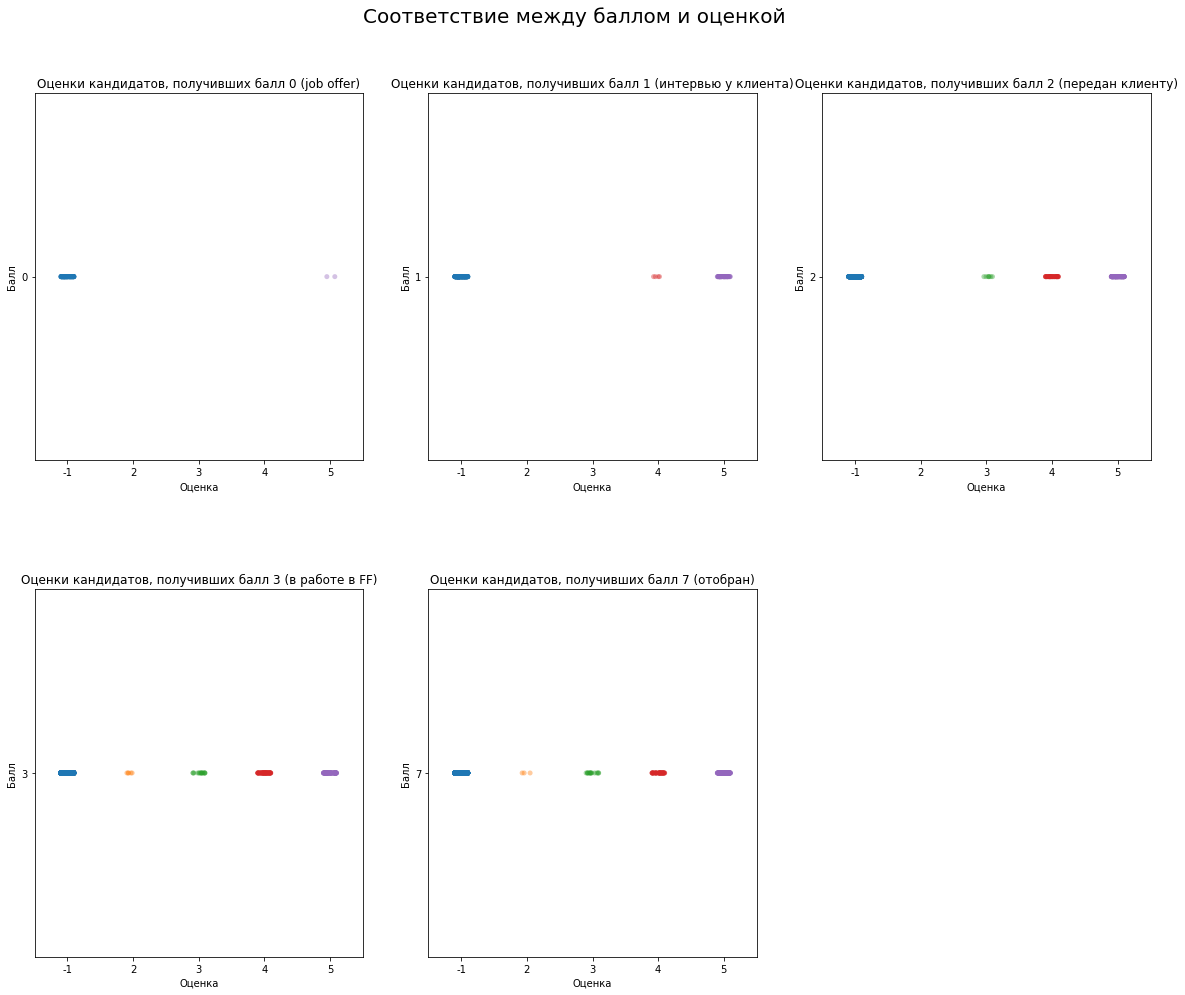

In [209]:
fig = plt.figure(figsize=(20,15))
plt.suptitle('Соответствие между баллом и оценкой', size = 20)
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
sns.despine()
plt.subplot(2, 3, 1)

res = data[data.res == 0]
sns.stripplot(x=df.mark, y=res.res, alpha=.40)
plt.title('Оценки кандидатов, получивших балл 0 (job offer)')
plt.xlabel('Оценка')
plt.ylabel('Балл')
plt.yticks([0], [0])

plt.subplot(2, 3, 2)
res = data[data.res == 1]
sns.stripplot(x=df.mark, y=res.res, alpha=.40)
plt.title('Оценки кандидатов, получивших балл 1 (интервью у клиента)')
plt.xlabel('Оценка')
plt.ylabel('Балл')
plt.yticks([1], [1])

plt.subplot(2, 3, 3)
res = data[data.res == 2]
sns.stripplot(x=df.mark, y=res.res, alpha=.40)
plt.title('Оценки кандидатов, получивших балл 2 (передан клиенту)')
plt.xlabel('Оценка')
plt.ylabel('Балл')
plt.yticks([2], [2])

plt.subplot(2, 3, 4)
res = data[data.res == 3]
sns.stripplot(x=df.mark, y=res.res, alpha=.40)
plt.title('Оценки кандидатов, получивших балл 3 (в работе в FF)')
plt.xlabel('Оценка')
plt.ylabel('Балл')
plt.yticks([3], [3])

plt.subplot(2, 3, 5)
res = data[data.res == 7]
sns.stripplot(x=df.mark, y=res.res, alpha=.40)
plt.title('Оценки кандидатов, получивших балл 7 (отобран)')
plt.xlabel('Оценка')
plt.ylabel('Балл')
plt.yticks([7], [7])


In [104]:
#Судя по графику, положительным соответствуют оценки 4 и 5. Обозначим их за 1, остальные за -1. Есть сомнения насчет 3. 
#В одном тесте присвоим ей -1, в другом 1. Обозначим их за 1, остальные за -1.

In [114]:
df1=df

In [115]:
#Сначала всключим оценку 3 в положительный класс

In [132]:
datum = df
datum['mark']=df['mark'].replace([3,4,5], 1)
datum['mark']=datum['mark'].replace([-1,2], -1)

<ipython-input-132-f3f54d17a039>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datum['mark']=df['mark'].replace([3,4,5], 1)
<ipython-input-132-f3f54d17a039>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datum['mark']=datum['mark'].replace([-1,2], -1)


In [138]:
datum

,res,res_word,mark,birth_year,price_cur,languages_level,ind
0,1,в работе в FF,-1,1981,300000,4,0
1,1,в работе в FF,1,1976,450000,4,1
2,1,в работе в FF,1,1976,450000,4,2
3,-1,интересен на будущее,1,1976,450000,4,3
4,-1,интересен на будущее,-1,1981,210000,4,4
...,...,...,...,...,...,...,...
34788,1,отобран,-1,1990,50000,3,34788
34789,1,отобран,-1,1986,70000,3,34789
34790,1,в работе в FF,-1,1987,150000,2,34790
34791,1,в работе в FF,-1,1981,220000,2,34791


In [139]:
#Оценим качество прогноза рекрутера

In [140]:
y_hr = datum['mark']
y_real = datum['res']

In [141]:
Counter(datum['mark'])

Counter({-1: 32292, 1: 2214})

In [142]:
f1_score(y_hr, y_real)

0.11854557529470362

In [143]:
accuracy_score(y_hr, y_real)

0.6922853996406422

In [144]:
precision_score(y_hr, y_real)

0.072620016273393

In [145]:
recall_score(y_hr, y_real)

0.3224932249322493

In [146]:
#Очевидно, по всем параметрам качество довольно низкое

In [147]:
#Теперь попробуем включить оценку 3 в отрицательный класс.

In [154]:
datum['mark']=df1['mark'].replace([4,5], 1)
datum['mark']=datum['mark'].replace([-1,2,3], -1)
y_hr = datum['mark']
y_real = datum['res']

<ipython-input-154-078a89e97a62>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datum['mark']=df1['mark'].replace([4,5], 1)
<ipython-input-154-078a89e97a62>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datum['mark']=datum['mark'].replace([-1,2,3], -1)


In [155]:
Counter(datum['mark'])

Counter({-1: 32292, 1: 2214})

In [156]:
f1_score(y_hr, y_real)

0.11854557529470362

In [157]:
accuracy_score(y_hr, y_real)

0.6922853996406422

In [158]:
recall_score(y_hr, y_real)

0.3224932249322493

In [153]:
#Вне зависимости от оценки 3 построенный нами классификатор дает лучшие результаты на кросс-валидации